# Idea
Do some Plotting of singular features

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd

In [3]:
import sys
sys.path.append('/home/<User>/repos/csg_is')

from py_dataset import get_all_files_df
from py_dataset import read_in_files
from py_dataset import feature_plotting

In [4]:
data_path = Path('/media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/')
assert data_path.exists()

In [5]:
df = get_all_files_df.main(data_path)
df.head(1)

txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device1/3_thetick_4h/collections.txt
txt file found, will drop /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/code&data/0_raw_collected_data/Heqing/device2/1_normal/note.txt
                                           file_path
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...
RangeIndex(start=0, stop=622, step=1)
filetype
csv    530
zip     92
Name: count, dtype: int64
                                           file_path filetype  filesize_bytes
0  /media/<User>/DC/MAP_CreationOfNewDatasetsForDFL/...      csv           49419
feature_family
SYS_data        92
KERN_data       91
FLS_data        91
RES_data        91
block_data      91
network_data    91
entropy_data    75
Name: count, dtype: int64


,file_path,filetype,filesize_bytes,researcher_name,device_name,experiment,feature_family,file_name,device
0,/media//DC/MAP_CreationOfNewDatasetsForDFL/...,csv,49419,Heqing,device1,1_normal,block_data,e4_5f_01_68_35_e6.csv,Heqing_device1


#### Get Single data
* device = Heqing_device2 => most data
* go through all features of each feature_family
    * for one 
        1. First: Sum up over all experiments/Malwares/labels first
        2. Then: Then only specific attack in comparison?
            * each column: normalize the data
            * plot boxplot: distribution

In [6]:
single_dev = df[df["device"] == "Heqing_device2"]
assert len(single_dev["device"].unique()) == 1

In [7]:
single_dev_single_data_source = single_dev[single_dev["data_source"] == "network_data"]
assert len(single_dev_single_data_source["data_source"].unique()) == 1
single_dev_single_data_source.shape

(19, 9)

In [56]:
all_net_vectors = read_in_files.get_all_columns_from_single_data_source_for_csv_files(single_dev_single_data_source)

In [57]:
print("len:", len(all_net_vectors))
all_net_vectors.columns

len: 3900580


Index(['Protocol', 'SourceIP', 'SourcePort', 'DestIP', 'DestPort', 'Length',
       'experiment'],
      dtype='object')

In [61]:
all_net_vectors[all_net_vectors.isna().all(axis=1)]

,Protocol,SourceIP,SourcePort,DestIP,DestPort,Length,experiment
timestamp,,,,,,,


In [10]:
all_net_vectors["label"].unique()

array(['1_normal', '2_ransomware', '3_thetick', '4_bashlite',
       '5_httpbackdoor', '6_beurk', '7_backdoor', '8_bdvl', '9_xmrig'],
      dtype=object)

### Net Feature Engineering
Group over sometime windows, BUT only of same label/experiment

In [139]:
def create_mean_net_df(df:pd.DataFrame, time_window = "40s") -> pd.DataFrame:
    series = []
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df.index)
    for timestamp, group_df in df.resample(time_window, origin='start'):
        if group_df.empty:
            features = {
                "timestamp": timestamp,
                "(OLD) PacketCount": 0,
                "(OLD) TotalLength": 0,
                "(OLD) AverageLength": 0,
                "(OLD) MedianLength": 0,
                "(OLD) MinLength": 0,
                "(OLD) MaxLength": 0,
                "(OLD) VarianceLength": 0,
                "(OLD) DifferentSourcePorts": 0,
                "(OLD) DifferentDestPorts": 0,
                "TcpPacketCount": 0,
                "UdpPacketCount": 0,
                "TcpUdpProtocolRatio": 0,
                "MeanInterPacketInterval": 0,
                "VarianceInterPacketInterval": 0,
                "MinInterPacketInterval": 0,
                "MaxInterPacketInterval": 0,
                "FirstDerivativeInterPacketInterval": 0,
                "SecondDerivativeInterPacketInterval": 0,
                "AverageBandwidth": 0,
                "VarianceBandwidth": 0,
                "MinBandwidth": 0,
                "MaxBandwidth": 0,
                "DifferentDestIPs": 0,
            }
            series.append(features)
            continue

        group_df = group_df.copy()        
        protocol_counts = group_df["Protocol"].value_counts()
        
        group_df['InterPacketInterval'] = group_df['timestamp'].diff().dt.total_seconds()
        # group_df['InterPacketInterval'] = group_df['InterPacketInterval'].fillna(0)
        # group_df.fillna({"InterPacketInterval": 0}, inplace=True)


        group_df['BytesPerSecond'] = group_df['Length'].div(group_df['InterPacketInterval']) 
        # group_df.fillna({"BytesPerSecond": 0}, inplace=True)
        group_df.replace({'BytesPerSecond': np.inf}, 0, inplace=True)
        
        if group_df['InterPacketInterval'].isna().any():
            x = group_df

        features = {
            "timestamp": timestamp,
            "(OLD) PacketCount": group_df.shape[0],
            "(OLD) TotalLength": group_df["Length"].sum(),
            "(OLD) AverageLength": group_df["Length"].mean(),
            "(OLD) MedianLength": group_df["Length"].median(),
            "(OLD) MinLength": group_df["Length"].min(),  
            "(OLD) MaxLength": group_df["Length"].max(),
            "(OLD) VarianceLength": group_df["Length"].var(),
            "(OLD) DifferentSourcePorts": group_df["SourcePort"].nunique(),
            "(OLD) DifferentDestPorts": group_df["DestPort"].nunique(),
            "TcpPacketCount": protocol_counts.get("TCP", 0),
            "UdpPacketCount": protocol_counts.get("UDP", 0),
            "TcpUdpProtocolRatio": protocol_counts.get("TCP", 0) / protocol_counts.get("UDP", 0.1),
            "MeanInterPacketInterval": group_df['InterPacketInterval'].mean(skipna=True),
            "VarianceInterPacketInterval": group_df['InterPacketInterval'].var(skipna=True),
            "MinInterPacketInterval": group_df['InterPacketInterval'].min(skipna=True),
            "MaxInterPacketInterval": group_df['InterPacketInterval'].max(skipna=True),
            "FirstDerivativeInterPacketInterval": group_df['InterPacketInterval'].diff().mean(skipna=True),
            "SecondDerivativeInterPacketInterval": group_df['InterPacketInterval'].diff().diff().mean(skipna=True),
            "AverageBandwidth": group_df['BytesPerSecond'].mean(skipna=True),
            "VarianceBandwidth": group_df['BytesPerSecond'].var(skipna=True),
            "MinBandwidth": group_df['BytesPerSecond'].min(skipna=True),
            "MaxBandwidth": group_df['BytesPerSecond'].max(skipna=True),
            "DifferentDestIPs": group_df["DestIP"].nunique(),
        }
        series.append(features)
    
    return pd.DataFrame(series).set_index("timestamp", inplace=False, drop=True)

In [140]:

sub_vectors = []
for label in all_net_vectors["label"].unique():
    mean_df = create_mean_net_df(all_net_vectors[all_net_vectors["label"] == label])
    mean_df["label"] = label
    sub_vectors.append(mean_df)

vectors = pd.concat(sub_vectors)

In [101]:
# sub_vectors = []
# for label in all_net_vectors["label"].unique():
#     to_use_df = all_net_vectors[all_net_vectors["label"] == label]
#     for _, group_df  in to_use_df.groupby("SourceIP"):
#         mean_df = create_mean_net_df(group_df)
#         mean_df["label"] = label
#         sub_vectors.append(mean_df)

# vectors = pd.concat(sub_vectors)

In [141]:
non_numeric_cols = vectors.select_dtypes(exclude=['number']).columns.tolist()
non_numeric_cols.remove("label")
for col in non_numeric_cols:
    vectors[col] = pd.to_numeric(vectors[col])
non_numeric_cols

[]

In [142]:
vectors.reset_index(inplace=True, drop=True)  # drop: "timestamp"
non_numeric_cols = vectors.select_dtypes(exclude=['number']).columns.tolist()
non_numeric_cols.remove("label")
for col in non_numeric_cols:
    vectors[col] = pd.to_numeric(vectors[col])
print("non numeric cols: ", non_numeric_cols)

cols_to_exclude_from_scaling = ["label"]

vectors_scaled = feature_plotting.minmax_scale_features(vectors,
                                                        remove_outliers_iqr_all_columns=False,
                                                        cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

vectors_robust_scaled = feature_plotting.minmax_scale_features(vectors,
                                                               remove_outliers_iqr_all_columns=True,
                                                               cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

non numeric cols:  []


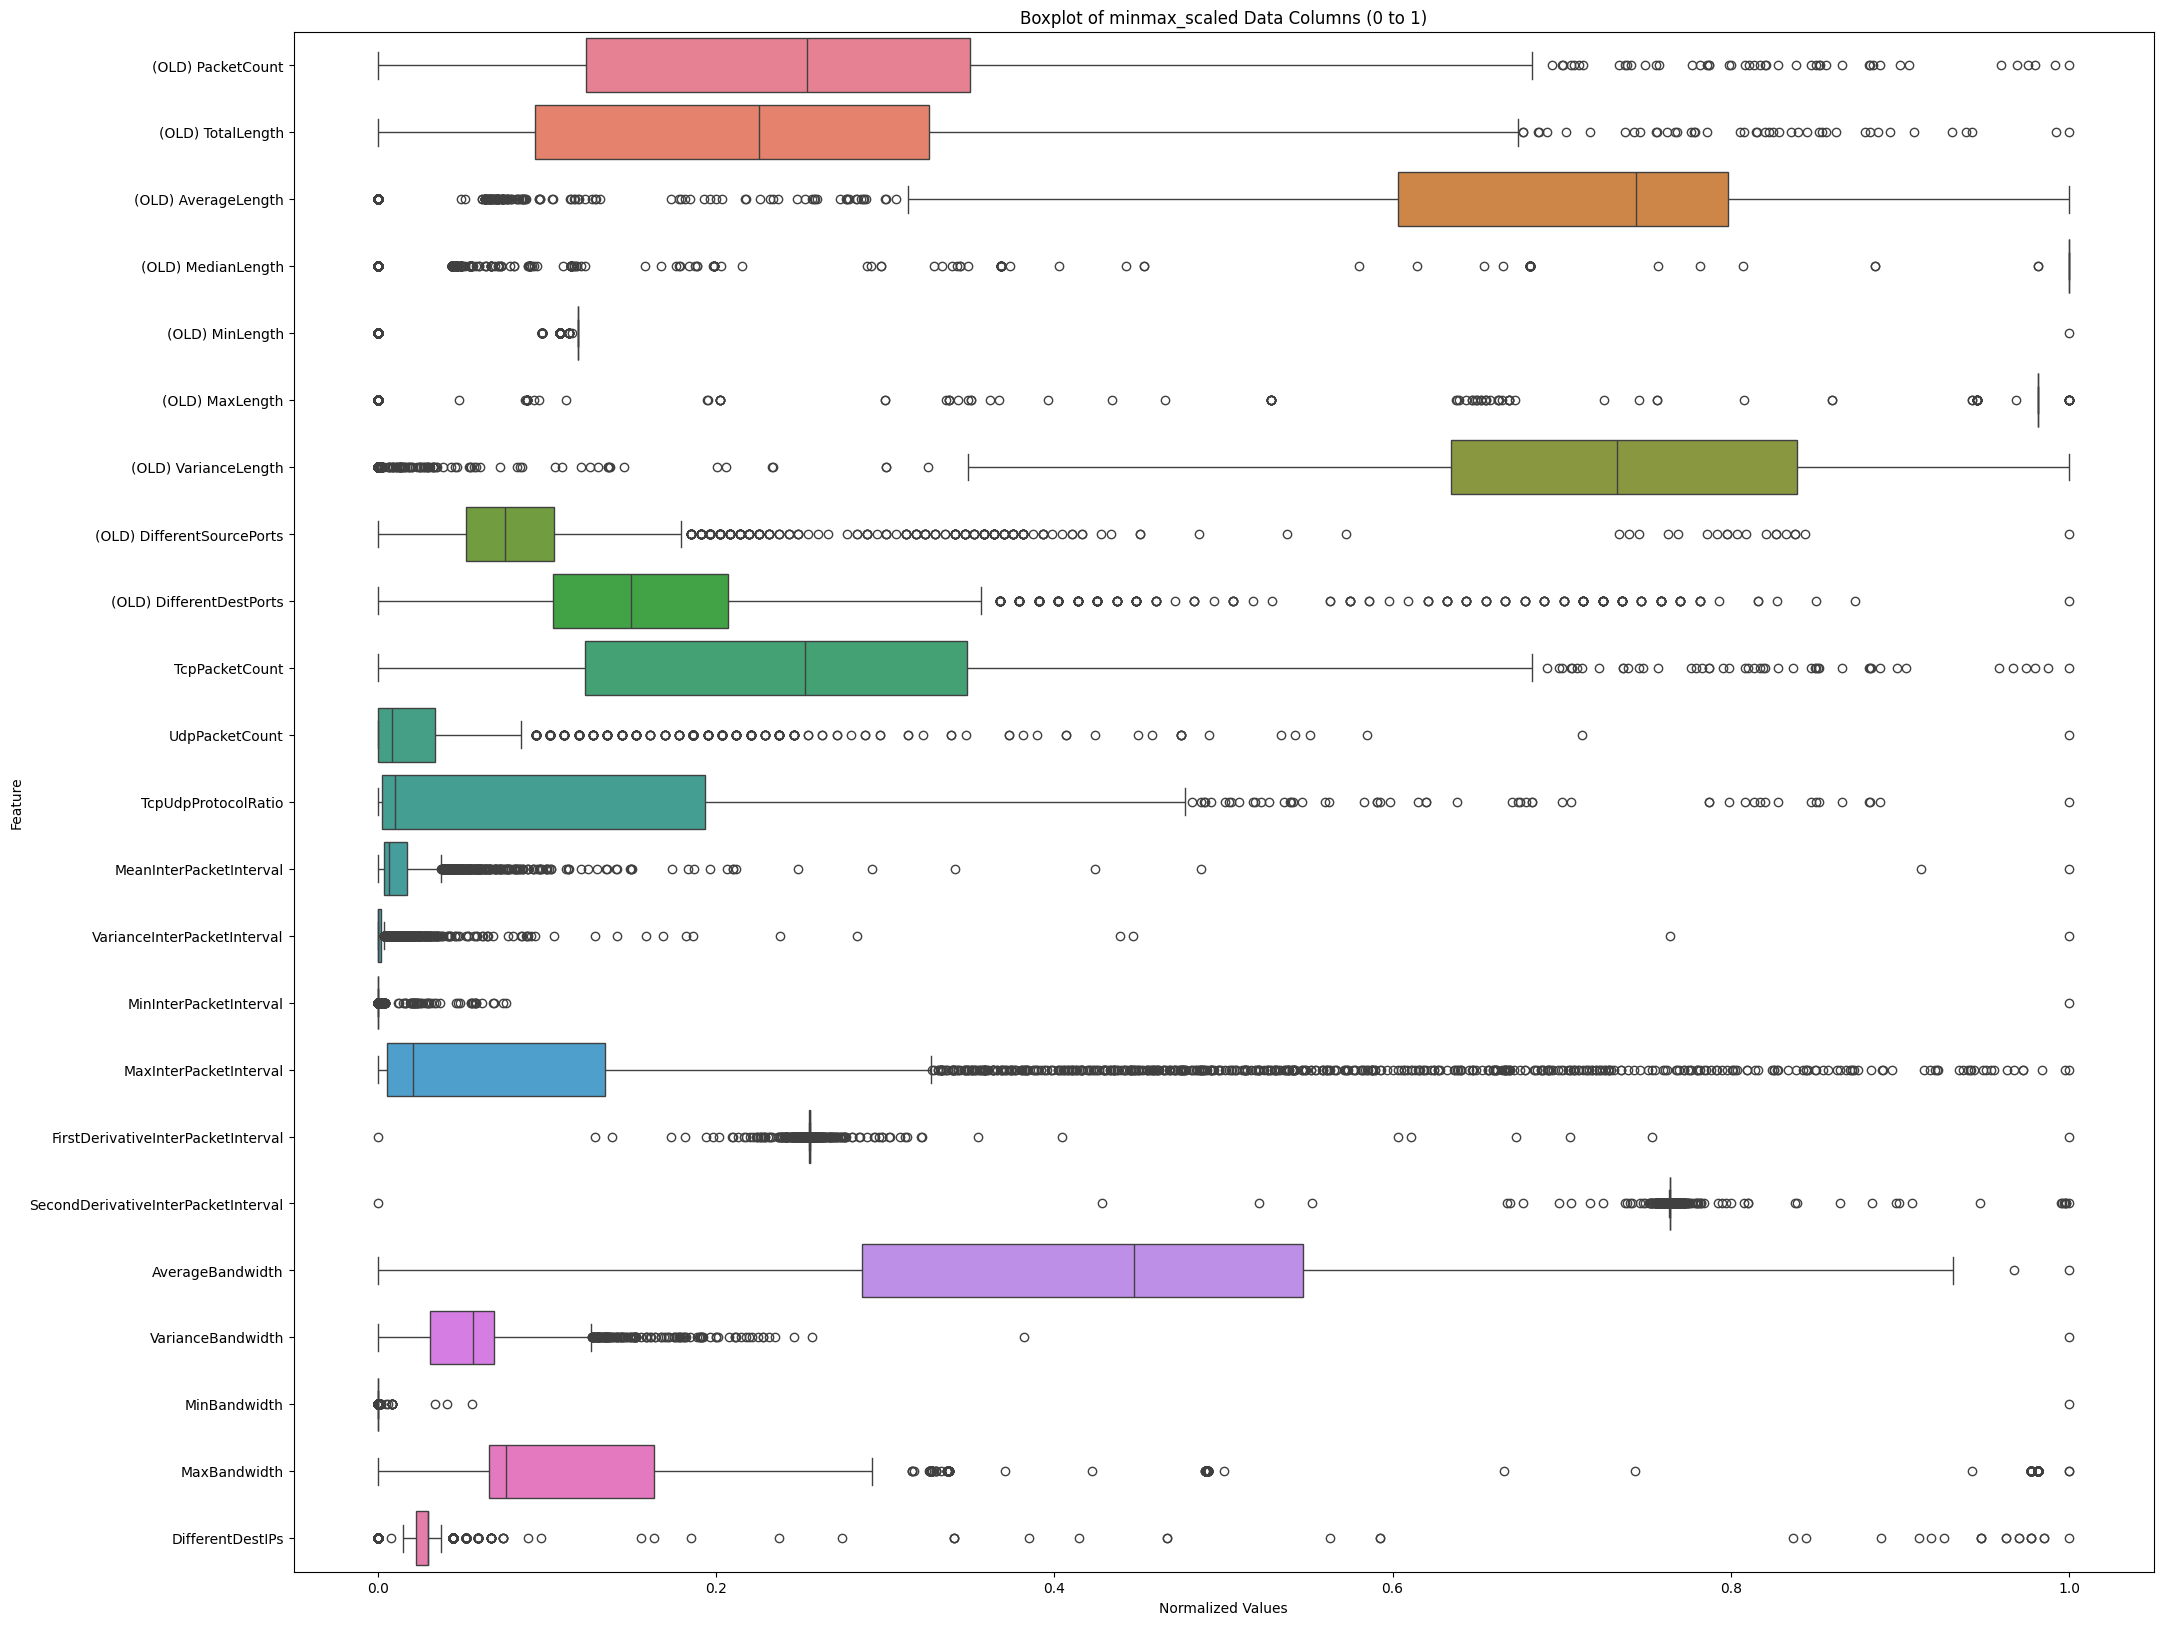

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 20))
sns.boxplot(data=vectors_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('Normalized Values')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1)')
plt.show()

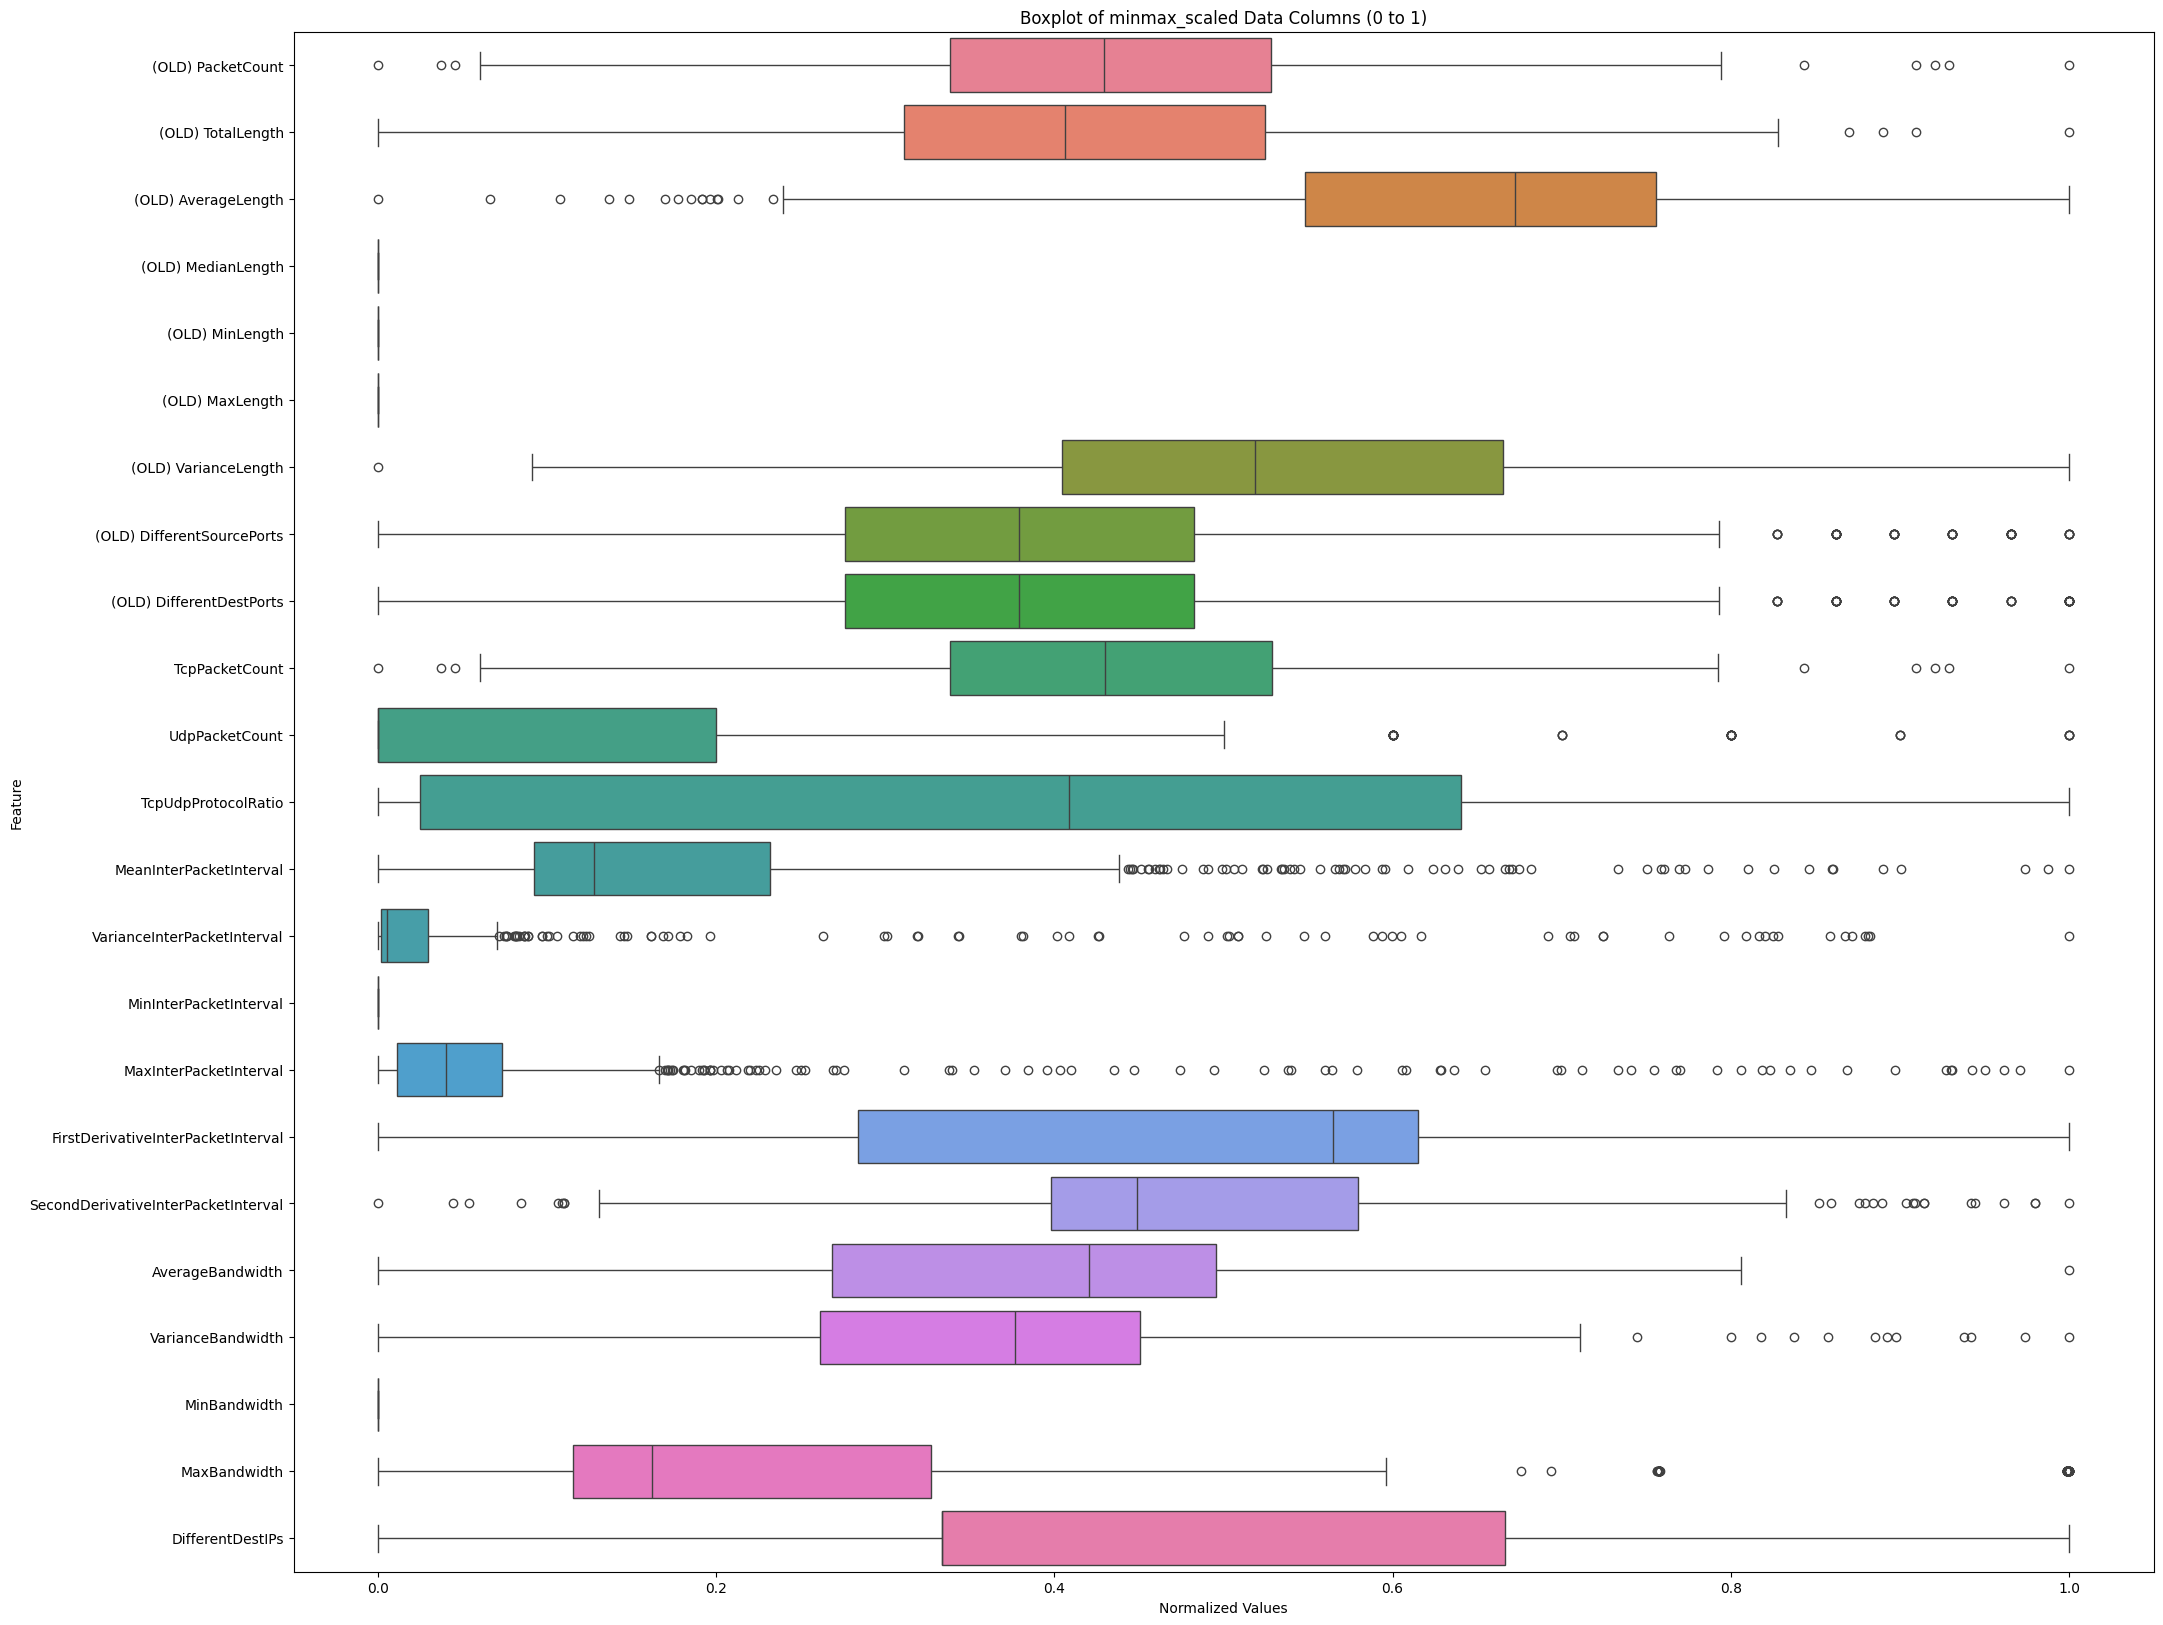

In [144]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 20))
sns.boxplot(data=vectors_robust_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

plt.ylabel('Feature')
# plt.xticks(rotation=45)
plt.xlabel('Normalized Values')

plt.title('Boxplot of minmax_scaled Data Columns (0 to 1)')
plt.show()

In [145]:
len(vectors.columns)

24

In [157]:
vectors_robust_scaled[vectors_robust_scaled["label"]=="3_thetick"].dropna()

,(OLD) PacketCount,(OLD) TotalLength,(OLD) AverageLength,(OLD) MedianLength,(OLD) MinLength,(OLD) MaxLength,(OLD) VarianceLength,(OLD) DifferentSourcePorts,(OLD) DifferentDestPorts,TcpPacketCount,...,MinInterPacketInterval,MaxInterPacketInterval,FirstDerivativeInterPacketInterval,SecondDerivativeInterPacketInterval,AverageBandwidth,VarianceBandwidth,MinBandwidth,MaxBandwidth,DifferentDestIPs,experiment


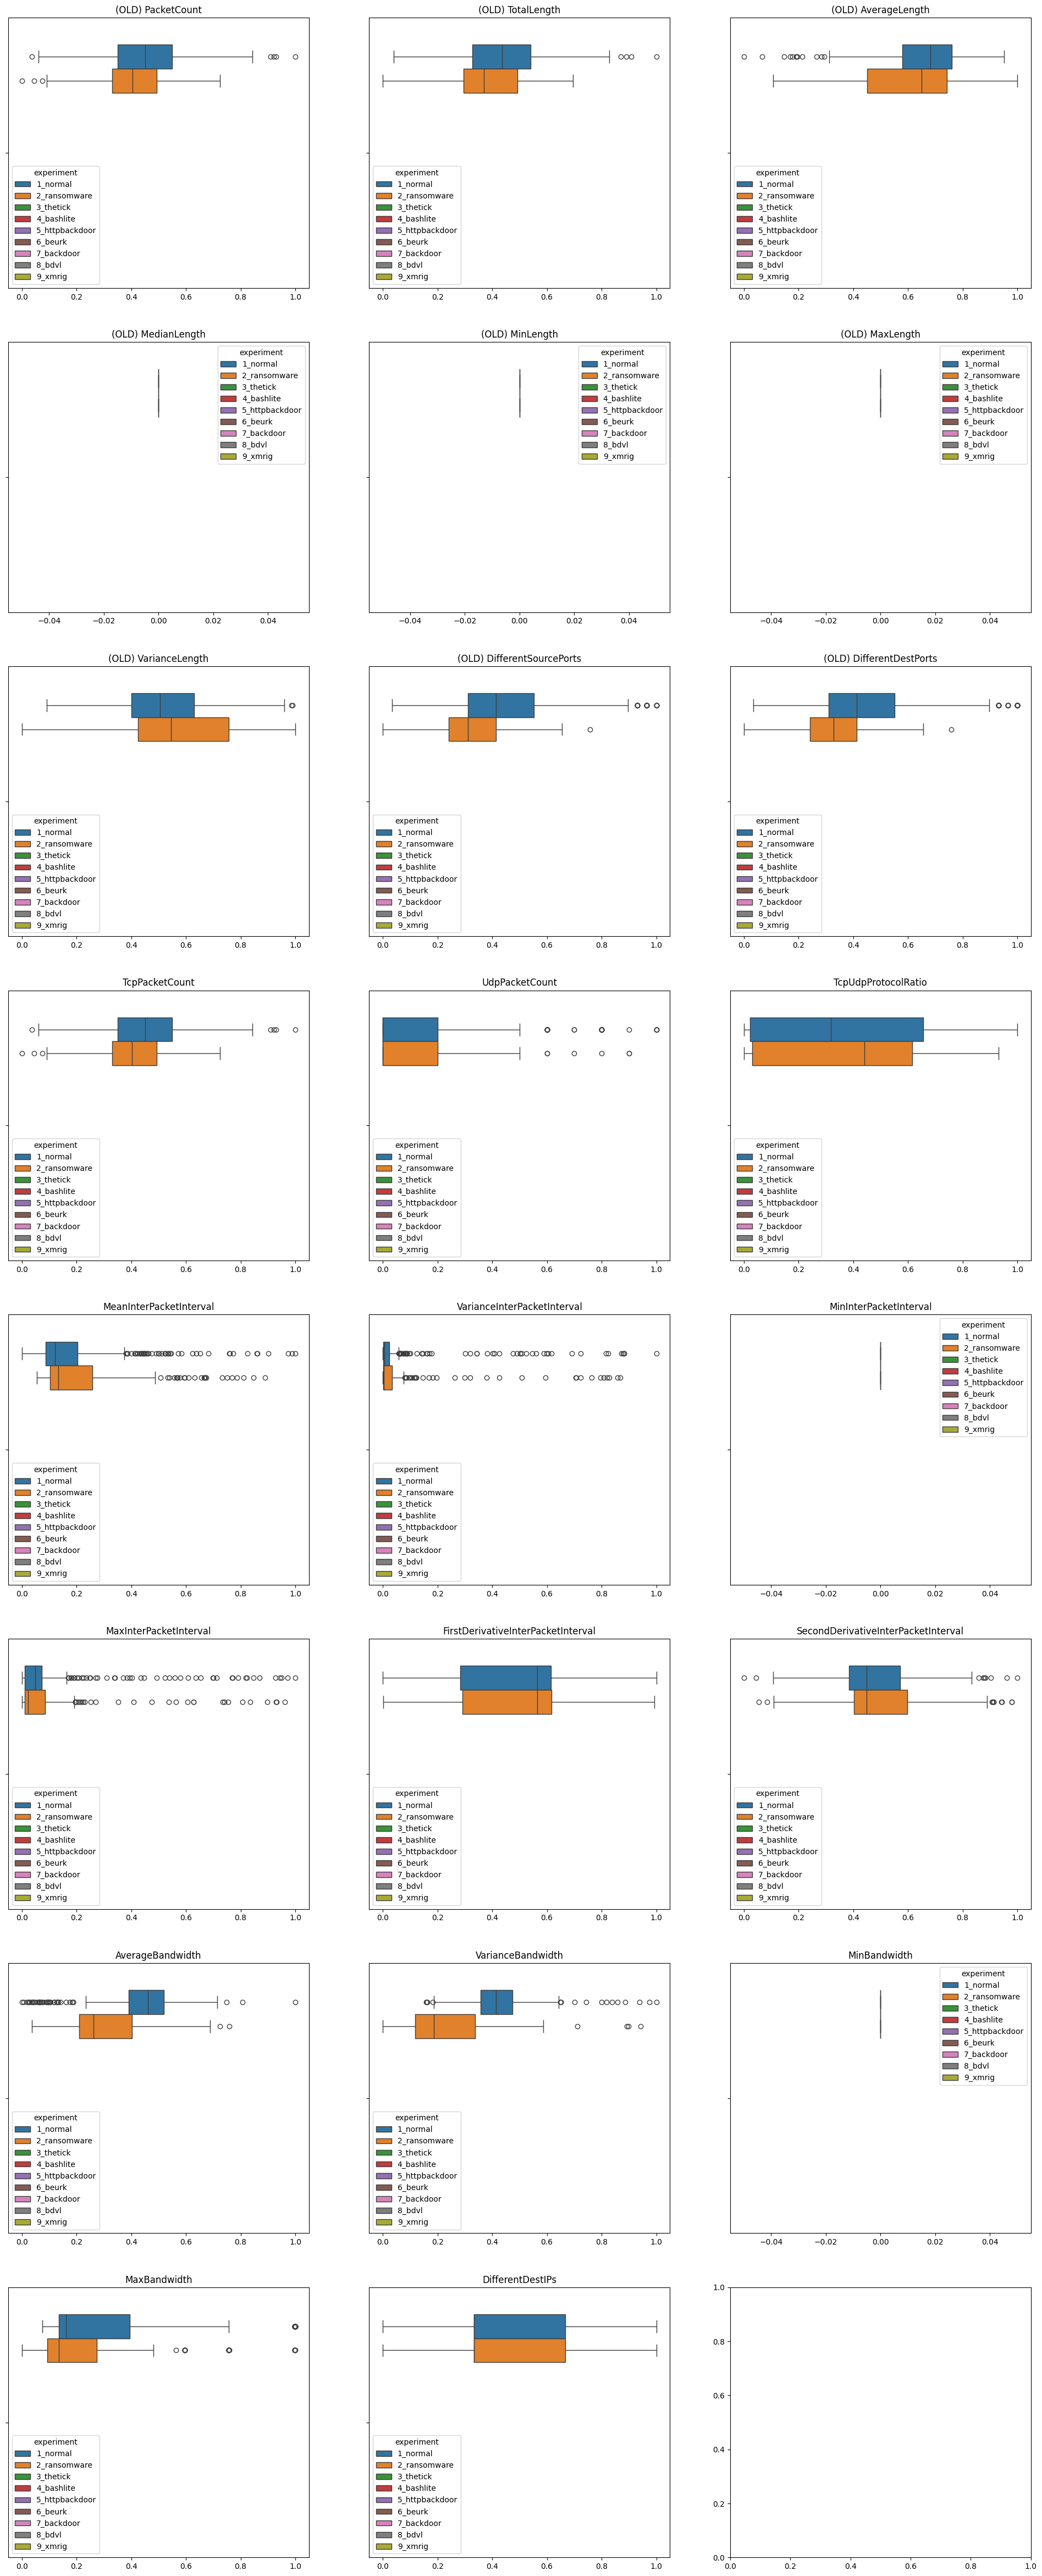

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 8))
# sns.boxplot(data=vectors_scaled, native_scale=True, orient="h")  # x="class", y="age", legend="full", 

fig, axs = plt.subplots(8, 3, figsize=(24, 60))

# Flatten the axes for easier indexing
axs = axs.flatten()

# labels = vectors_scaled["label"].unique()
# handles, labels = axs[0].get_legend_handles_labels()

# Plot each column as a boxplot
for i, column in enumerate(vectors_scaled.columns):
    if column == "label":
        continue

    sns.boxplot(data=vectors_robust_scaled, x=column, ax=axs[i], hue="label", native_scale=True, orient="h",
                legend=True)
    axs[i].set_title(f'{column}')
    axs[i].set_xlabel('')

# axs[1].legend(['Survived', 'Not Survived'])

# plt.ylabel('Columns')
# plt.xticks(rotation=45)
# plt.xlabel('Values')
# plt.legend(loc='upper right')
# plt.tight_layout()
# labels = vectors_scaled["label"].unique()
# # handles, labels = axs[0].get_legend_handles_labels()
# plt.legend(labels, loc='upper right')
plt.show()

#### Make a narrow dataset

In [149]:
vectors_scaled.head(1)

,(OLD) PacketCount,(OLD) TotalLength,(OLD) AverageLength,(OLD) MedianLength,(OLD) MinLength,(OLD) MaxLength,(OLD) VarianceLength,(OLD) DifferentSourcePorts,(OLD) DifferentDestPorts,TcpPacketCount,...,MinInterPacketInterval,MaxInterPacketInterval,FirstDerivativeInterPacketInterval,SecondDerivativeInterPacketInterval,AverageBandwidth,VarianceBandwidth,MinBandwidth,MaxBandwidth,DifferentDestIPs,experiment
0,0.316497,0.313586,0.819216,1.0,0.11828,0.981842,0.646154,0.086705,0.183908,0.310387,...,0.0,0.055126,0.254953,0.763889,0.585587,0.064915,0.0,0.098019,0.037037,1_normal


In [150]:
narrow_df = pd.melt(vectors_scaled, id_vars=['experiment'], var_name='x', value_name='y')
narrow_df.head(1)

,experiment,x,y
0,1_normal,(OLD) PacketCount,0.316497


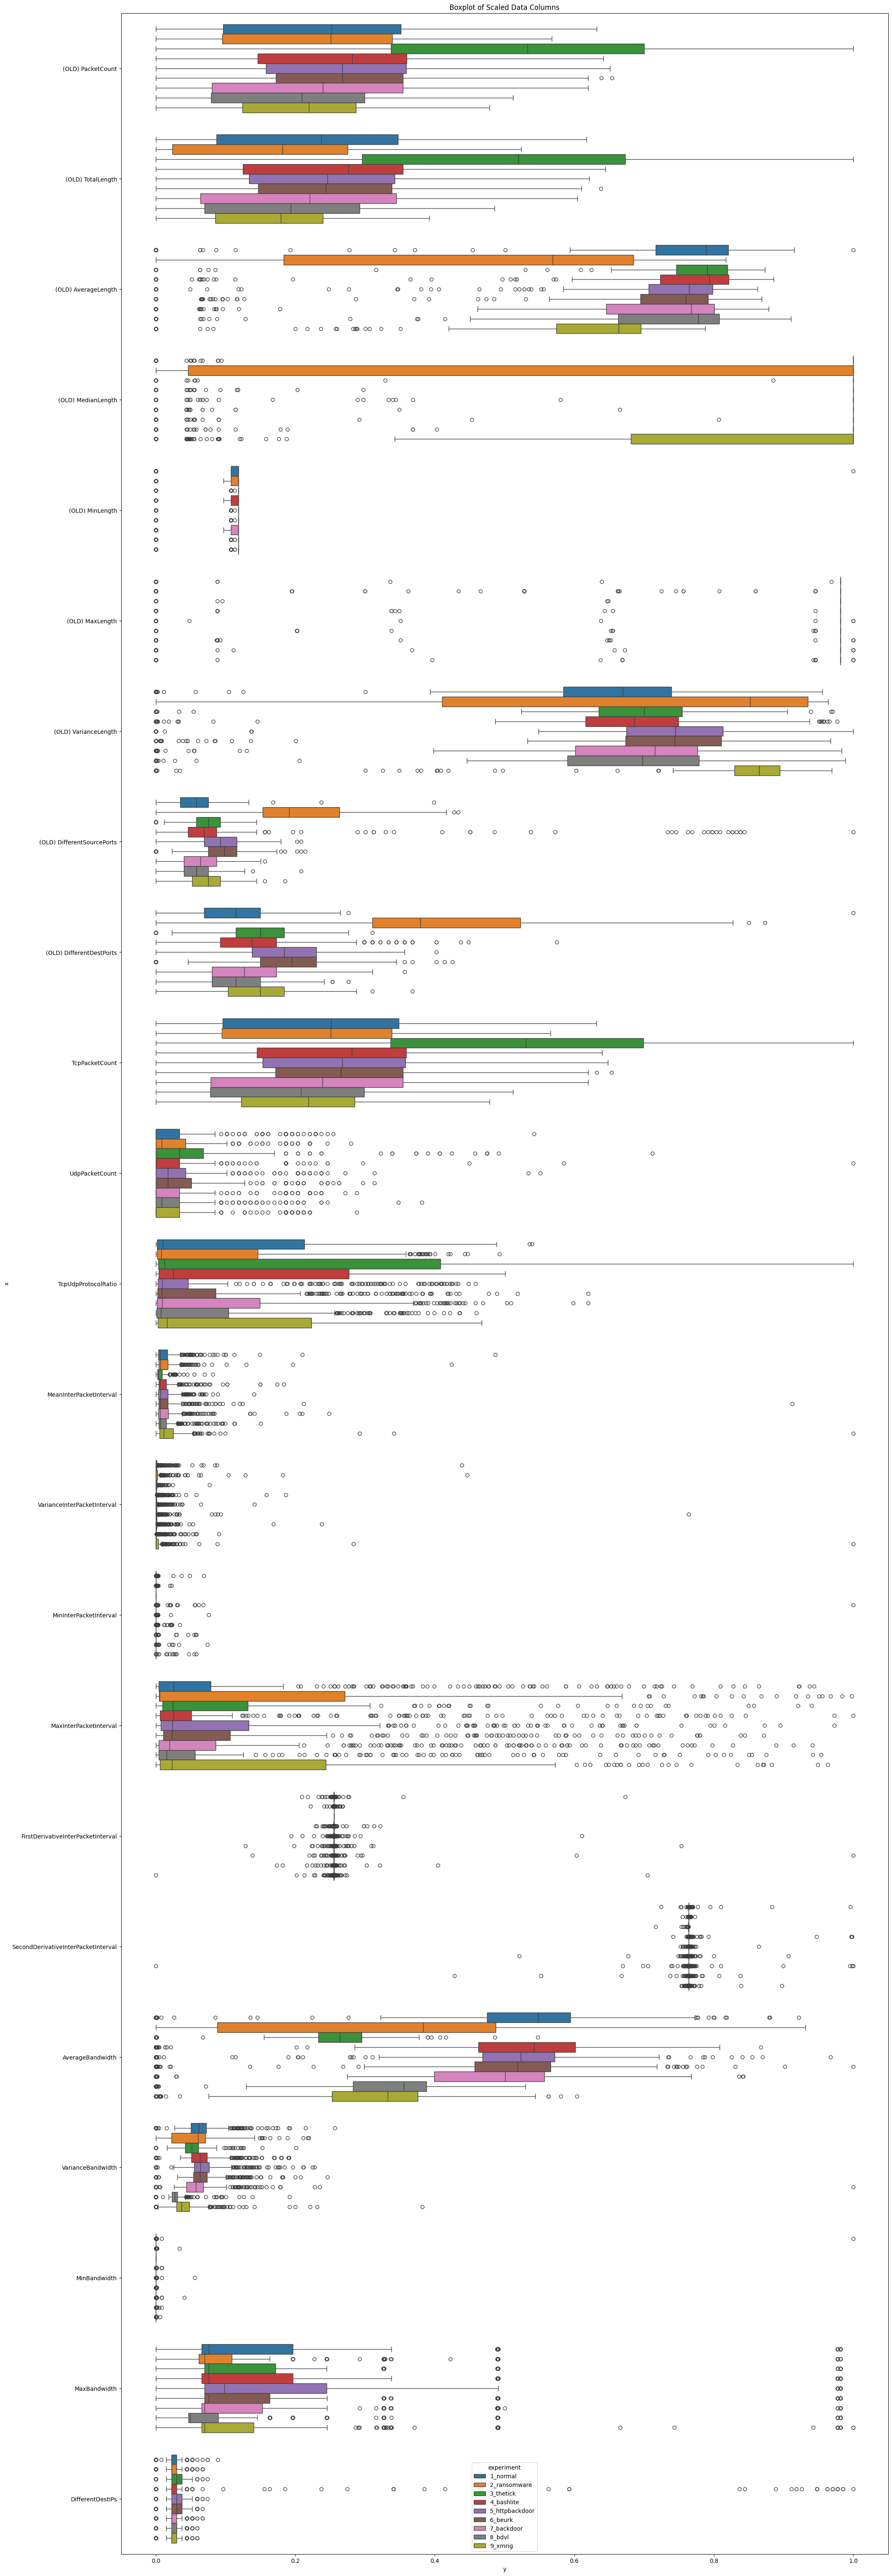

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 80))
# sns.boxplot(data=narrow_df, x="x", y="y"
# hue = "label")  # x="class", y="age", legend="full", native_scale=True,
sns.boxplot(data=narrow_df, x="y", y="x", orient="h",legend="full",
            hue="label")

# plt.ylabel('Columns')
# # plt.xticks(rotation=45)
# plt.xlabel('Values')

plt.title('Boxplot of Scaled Data Columns')
plt.show()

In [ ]:
assert False, "Stop here, doesnt make sense anyway"

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 90))
# sns.boxplot(data=narrow_df, x="label", y="y",  #orient="h",
#             hue="x")  # x="class", y="age", legend="full", native_scale=True,
sns.boxplot(data=narrow_df, x="y", y="x", orient="h",
            hue="label")

# plt.ylabel('Columns')
# # plt.xticks(rotation=45)
# plt.xlabel('Values')

plt.title('Boxplot of Scaled Data Columns')
plt.show()

# Try PCA

In [121]:
vectors.dropna().iloc[:, :-1].columns

Index(['PacketCount', 'TotalLength', 'AverageLength', 'MedianLength',
       'MinLength', 'MaxLength', 'VarianceLength', 'DifferentSourcePorts',
       'DifferentDestPorts', 'TcpPacketCount', 'UdpPacketCount',
       'TcpUdpProtocolRatio', 'MeanInterPacketInterval',
       'VarianceInterPacketInterval', 'MinInterPacketInterval',
       'MaxInterPacketInterval', 'FirstDerivativeInterPacketInterval',
       'SecondDerivativeInterPacketInterval', 'AverageBandwidth',
       'VarianceBandwidth', 'MinBandwidth', 'MaxBandwidth',
       'DifferentDestIPs'],
      dtype='object')

In [122]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Initialize a list to store the explained variance ratios
explained_variance_ratios = []

# Perform PCA in several rounds, varying the number of components
for n_components in range(1, 11):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(vectors.dropna().iloc[:, :-1])
    explained_variance_ratios.append(pca.explained_variance_ratio_.sum())

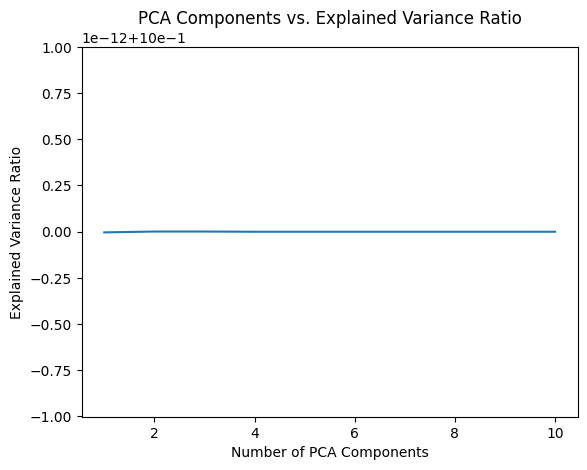

[0.9999999999999954,
 1.0,
 1.0,
 0.9999999999999988,
 0.9999999999999988,
 0.9999999999999988,
 0.9999999999999988,
 0.9999999999999988,
 0.9999999999999988,
 0.9999999999999988]

In [123]:
# Plot the explained variance ratios
plt.plot(range(1, 11), explained_variance_ratios)
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Components vs. Explained Variance Ratio')
plt.show()
explained_variance_ratios

In [124]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(vectors.dropna().iloc[:, :-1])
print(pca.explained_variance_ratio_.sum())
X_pca.shape

0.9999999999999954


(3246, 1)

In [125]:
X_pca = np.column_stack((X_pca, vectors.dropna().iloc[:, -1:]))

df_pca = pd.DataFrame(X_pca, columns=['pca', 'label'])

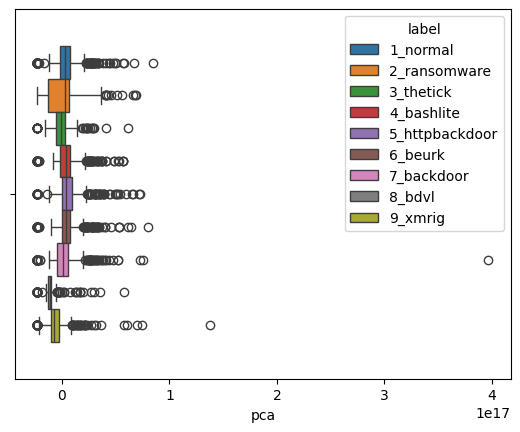

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.plot(figsize=(16, 10))

sns.boxplot(data=df_pca, x="pca", hue="label", native_scale=True, orient="h",
            legend=True)
plt.show()